# Example for Layered Case

Here, we show an example of how to use the package for layered background velocities, i.e., cases where we can use translation invariance. Care must be taken that the geometric optics assumption does not break down.

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse as sp


# Package functions hiding heavy lifting :)
from grt_inversion import layered_velocity, one_velocity, extend_and_solve, generate_data, plot, compute_tau_and_a, generate_data_general
from grt_inversion.reconstruction.translation_invariant.data_generation import n_func
from grt_inversion.reconstruction.translation_invariant import compute_ref_kernels, interpolate_kernels_fast_safe
from grt_inversion.utils import cutoff

# Determine whether you want to save the generated kernels or load them.
SAVE = False #True
LOAD = False


In [4]:
# Setup grid data for domain
nx, ny = 121, 121
a = 10
x, y = np.linspace(-a, a, nx), np.linspace(0, 20, ny)

dx = (abs(x[1] - x[0]), abs(y[1] - y[0]))
alpha = 5

# Choose background velocity
# velocity = one_velocity
velocity = layered_velocity

# Compute integration factor and assemble travel time function
I_M, phi_vals = extend_and_solve(x, y, dx, alpha, velocity)


# Setup for data space
t_data = np.linspace(phi_vals.min(), phi_vals.max(), 701)
s_data = np.linspace(-10, 10, 301)

# Generate data
g = generate_data(s_data, t_data, phi_vals, dx, I_M, x[0], n_func)

# Plot generated data
# plot(s_data, t_data, g)


Negative denominator: forward scattering or numerical instability.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 686 out of 701 | elapsed:   10.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 701 out of 701 | elapsed:   10.5s finished


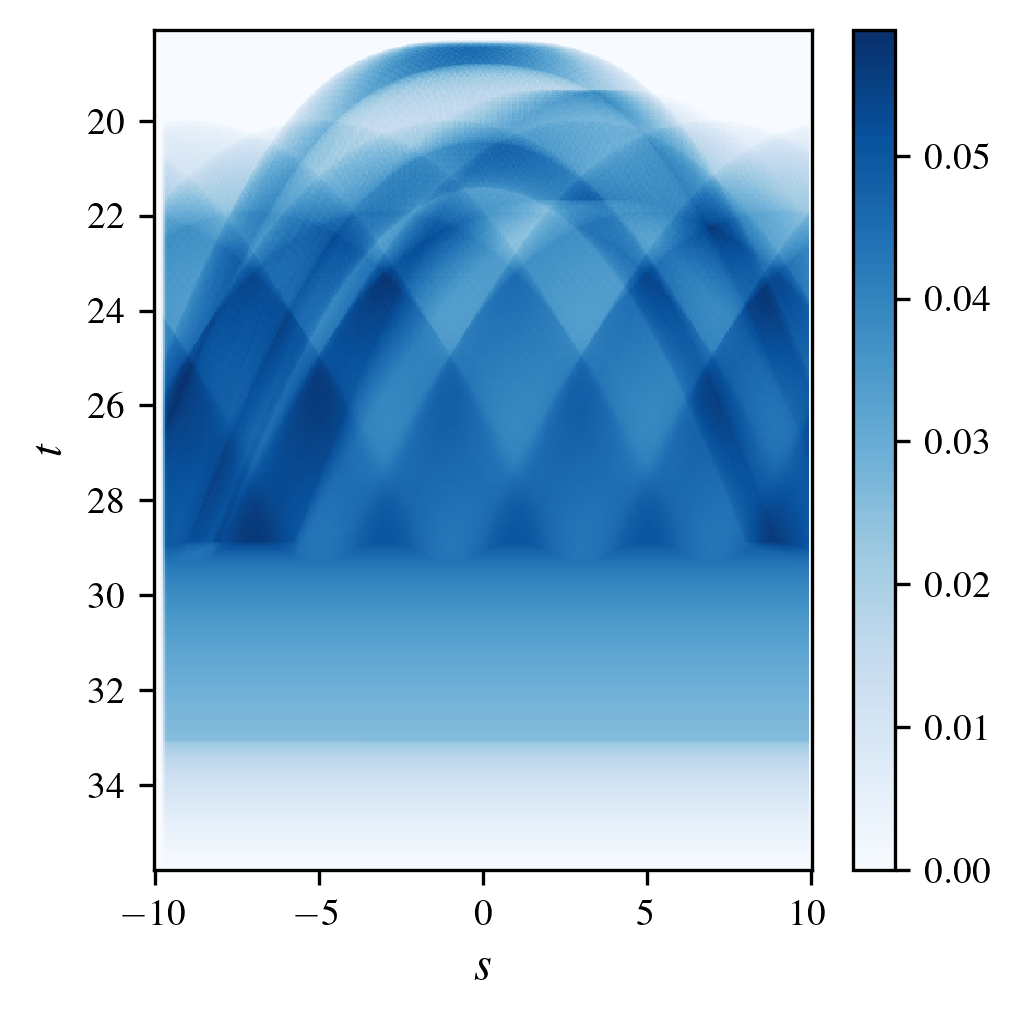

In [13]:
# Plot
S, T = np.meshgrid(s_data, t_data, indexing='ij')

with mpl.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],  
    "axes.labelsize": 11,     
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 300,       
    "axes.linewidth": 0.8,    
    "lines.linewidth": 1.0,
    "lines.markersize": 4,    
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"
}):
    plt.figure(figsize=(3.5, 3.5))
    plt.pcolormesh(S, T, g, shading='auto', cmap='Blues')
    plt.colorbar()
    plt.xlabel(r"$s$")
    plt.ylabel(r"$t$")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [6]:
# Reconstruction parameters for GRT
ns = len(s_data)
nt = len(t_data)
s_vals = np.linspace(s_data[0], s_data[-1], ns) # Source positions
t_vals = np.linspace(t_data[0], t_data[-1], nt)  # Time samples

# Reconstruction parameters for reconstruction kernels
q, k = 2, 3 
gamma = .2

# Setup for translation invariant case
s_mid = s_vals[len(s_vals)//2]

# Values p where we determine the reconstruction
p1_vals = x 
p_ref_vals = y
p2_vals = p_ref_vals

ds = s_vals[1] - s_vals[0]

p_ref = int(max(abs(s_mid - p1_vals)))
n_ref = int(ns + 2 * p_ref/ds) + 1

s_ref = np.linspace(s_vals[0] - p_ref, s_vals[-1] + p_ref, n_ref)



In [7]:
if not LOAD:
    ref_kernels = compute_ref_kernels(p1_vals, p2_vals, p_ref_vals, s_vals, t_vals, 
                        s_mid, gamma, q, k, phi_vals, dx, s_ref, I_M, x_origin=x[0], beta = 0)
    


Processing 121 kernels in 9 batches of size ~15
Processing batch 1/9 with 15 kernels
Memory usage after batch 1: 92.0%
Processing batch 2/9 with 15 kernels
Memory usage after batch 2: 91.8%
Processing batch 3/9 with 15 kernels
Memory usage after batch 3: 91.7%
Processing batch 4/9 with 15 kernels
Memory usage after batch 4: 91.6%
Processing batch 5/9 with 15 kernels
Memory usage after batch 5: 91.6%
Processing batch 6/9 with 15 kernels
Memory usage after batch 6: 91.5%
Processing batch 7/9 with 15 kernels
Memory usage after batch 7: 91.6%
Processing batch 8/9 with 15 kernels
Memory usage after batch 8: 91.5%
Processing batch 9/9 with 1 kernels
Memory usage after batch 9: 91.5%
no interpolation needed in p


In [8]:
if SAVE:
    # Save file
    filename = f"ref_kernels_101.npy"
    np.save(filename, ref_kernels)
    print(f"Saved to: {filename}")

if LOAD:
    # Load file
    ref_kernels = np.load('ref_kernels.npy')
    print("kernel loaded")


In [9]:
if np.any(s_vals != s_data) or np.any(t_vals != t_data):
    print("Interpolating kernels in parallel...")
    # Automatic selection based on problem size
    kernel_data = interpolate_kernels_fast_safe(ref_kernels, s_vals, t_vals, s_data, t_data, n_jobs=-1, method='auto')
    print("kernels interpolated")
else:
    print("No interpolation needed - using ref_kernels directly")
    kernel_data = ref_kernels

No interpolation needed - using ref_kernels directly


In [10]:
# Take inner products to compute approximate inversion
dt = t_data[1] - t_data[0]
ds = s_data[1] - s_data[0]
 
result = np.zeros((len(p1_vals), len(p2_vals)))

# Apply cutoff function
psi_g = sp.csr_matrix(cutoff(g, s_data, t_data))
# g = sp.csr_matrix(g)

for i in range(len(p1_vals)):
    for j in range(len(p2_vals)):
        K = sp.csr_matrix(kernel_data[i, j, :, :])
        #print(K.shape, g.shape)
        if sp.issparse(K):
            result[i, j] = ds * dt * np.sum(K.multiply(psi_g))
            #result[i, j] = ds * dt * np.sum(K.multiply(g))
        else:
            result[i, j] = ds * dt  * np.sum(K * psi_g)
            #result[i, j] = ds * dt  * np.sum(K * g)

In [11]:
if SAVE:
    # Save file
    filename = f"result.npy"
    np.save(filename, result)
    print(f"Saved to: {filename}")

#if LOAD:
#    result = np.load('result.npy') # Load file


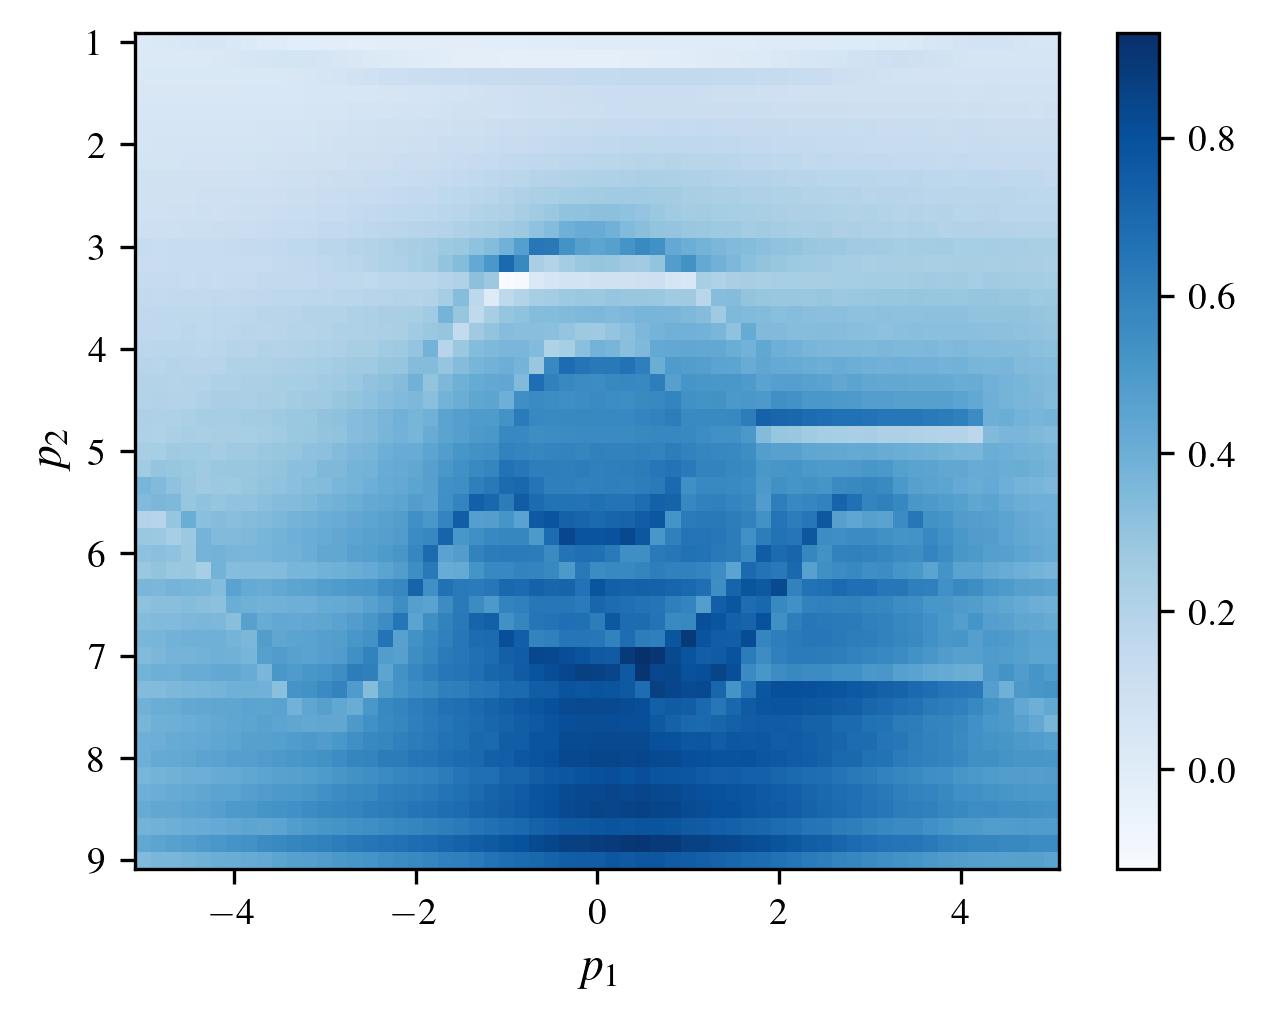

In [12]:
# Plot region of interest

# Filter the 1D coordinate arrays first
p1_mask = (p1_vals >= -5) & (p1_vals <= 5)
p2_mask = (p2_vals >= 1) & (p2_vals <= 9)

p1_sel = p1_vals[p1_mask]
p2_sel = p2_vals[p2_mask]

# Slice the result accordingly
result_sel = result[np.ix_(p1_mask, p2_mask)]

# Create meshgrid for plotting
P1, P2 = np.meshgrid(p1_sel, p2_sel, indexing='ij')

# Plot

with mpl.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],  
    "axes.labelsize": 11,     
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 300,       
    "axes.linewidth": 0.8,    
    "lines.linewidth": 1.0,
    "lines.markersize": 4,    
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"
}):
    plt.figure(figsize=(4.5, 3.5))
    plt.pcolormesh(P1, P2, result_sel, shading='auto', cmap='Blues')
    plt.colorbar()
    plt.xlabel(r"$p_1$")
    plt.ylabel(r"$p_2$")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()